In [317]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [318]:
DATASET_PAT = './train.csv'

In [319]:
df = pd.read_csv(DATASET_PAT, sep=',')
df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


Процедура для вывода результата

In [320]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [321]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


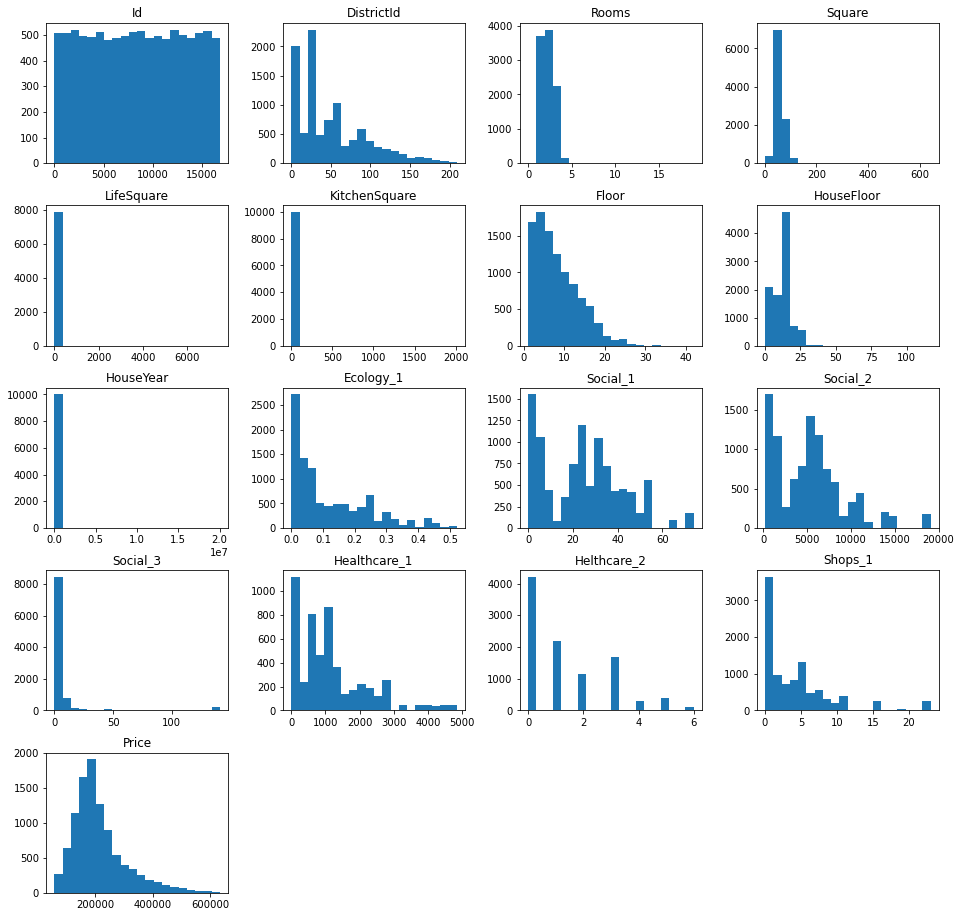

In [322]:
df.hist(figsize=(16,16), bins=20, grid=False);

Заполним пропуски в Healthcare_1 медианой

In [323]:
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

Примем за минимально возможную общую площадь 10  

In [324]:
df.loc[df['Square'] < 10, 'Square'] = 10

Если кухня есть(не = 0), то минимальная её площадь = 4  

In [325]:
df.loc[(df['KitchenSquare'] < 4) & (df['KitchenSquare'] > 0) , 'KitchenSquare'] = 4

Так как пропуски есть только в LifeSquare, но нету в общей площади и площади кухни, то заменим пустые значения в LifeSquare по формуле = (общая площадь - площадь кухни - 10)

In [326]:
LifeSquare_Nan = df[df['LifeSquare'].isnull()].index
print(len(LifeSquare_Nan))

2113


In [327]:
df.loc[LifeSquare_Nan, 'LifeSquare'] = (df.loc[LifeSquare_Nan, 'Square'] - df.loc[LifeSquare_Nan, 'KitchenSquare'] - 10)

Смотрим в скольких строках этаж превышает этажность дома.

In [328]:
floor_out = df[df['Floor'] > df['HouseFloor']].index
print(len(floor_out))

1825


Если этаж превышает максимальную этажность дома, то заменим его на этажность дома (то есть предполагаем, что это просто квартира на последнем этаже)

In [329]:
df.loc[floor_out, 'Floor'] = df.loc[floor_out, 'HouseFloor']

У тех квартир общая площадь которых превыщает сумму жилой + кухни меняем на сумму жилой + кухни меняем количество комнат меньше 1 и больше или равной 6 на 2 комнаты(медианное значение)

In [330]:
square_out = df[df['Square'] <  df['LifeSquare'] + df['KitchenSquare']].index
print(len(square_out))

1067


In [331]:
df.loc[square_out, 'Square'] = df.loc[square_out, 'LifeSquare'] + df.loc[square_out, 'KitchenSquare']

In [332]:
df.loc[df['Rooms'] >= 6, 'Rooms'] = 2
df.loc[df['Rooms'] < 1, 'Rooms'] = 2

Если год постройки дома больше 2021 и меньше 1914 меняем его на медиану (всего 5 таких значений)

In [333]:
Year_out = df[(df['HouseYear'] > 2021) | (df['HouseYear'] < 1914) ].index
df.loc[Year_out, 'HouseYear'] = int(df['HouseYear'].median())

Ограничим диапазон выборки по площади квартиры 1 и 99 квантилем

In [334]:
df = df[(df['Square'] < df['Square'].quantile(.99)) & (df['Square'] > df['Square'].quantile(.01))]

In [335]:
df = df[(df['LifeSquare'] < df['LifeSquare'].quantile(.99)) & (df['LifeSquare'] > df['LifeSquare'].quantile(.01))]

Обрабатываем категориальные признаки

In [336]:
df['Ecology_2'].value_counts()

B    9512
A      92
Name: Ecology_2, dtype: int64

In [337]:
df['Ecology_3'].value_counts()

B    9333
A     271
Name: Ecology_3, dtype: int64

In [338]:
df['Shops_2'].value_counts()

B    8837
A     767
Name: Shops_2, dtype: int64

In [339]:
df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})

In [340]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000,9604.000000
mean,8390.535194,50.580904,1.877655,55.817503,37.576329,6.581008,7.751770,12.699292,1984.611308,0.119211,24.900666,5394.615160,8.015827,1027.888484,1.323407,4.251562,212987.307720,0.990421,0.971783,0.920137
std,4860.293754,43.867937,0.795649,16.591952,15.549380,3.726794,5.256576,6.650539,18.209691,0.119415,17.515615,4005.365512,23.676738,749.609244,1.486847,4.793195,90410.590964,0.097409,0.165602,0.271094
min,0.000000,0.000000,1.000000,30.306381,3.489694,0.000000,0.000000,0.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,4169.500000,19.000000,1.000000,42.330114,24.966272,4.000000,4.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,154300.052048,1.000000,1.000000,1.000000
50%,8399.500000,37.000000,2.000000,52.787600,34.010414,6.000000,7.000000,14.000000,1977.000000,0.075779,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192072.978769,1.000000,1.000000,1.000000
75%,12605.250000,75.000000,2.000000,65.889736,47.062402,9.000000,11.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1015.000000,2.000000,6.000000,248120.782476,1.000000,1.000000,1.000000
max,16798.000000,209.000000,5.000000,121.875013,89.113486,84.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


In [341]:
district_size = df['DistrictId'].value_counts(normalize = True).reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
df = df.merge(district_size, on='DistrictId', how='left')

Обучение модели и получение оценки качества модели

In [342]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize']

In [343]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'DistrictSize']

In [344]:
target_name = 'Price'

In [345]:
X = df[feature_names]
y = df[target_name]

In [346]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

In [347]:
rf_model = RandomForestRegressor(
    max_depth=8, min_samples_split=100, n_estimators=500, n_jobs=-1, random_state=39
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500,
                      n_jobs=-1, random_state=39)

Train R2:	0.734
Valid R2:	0.698


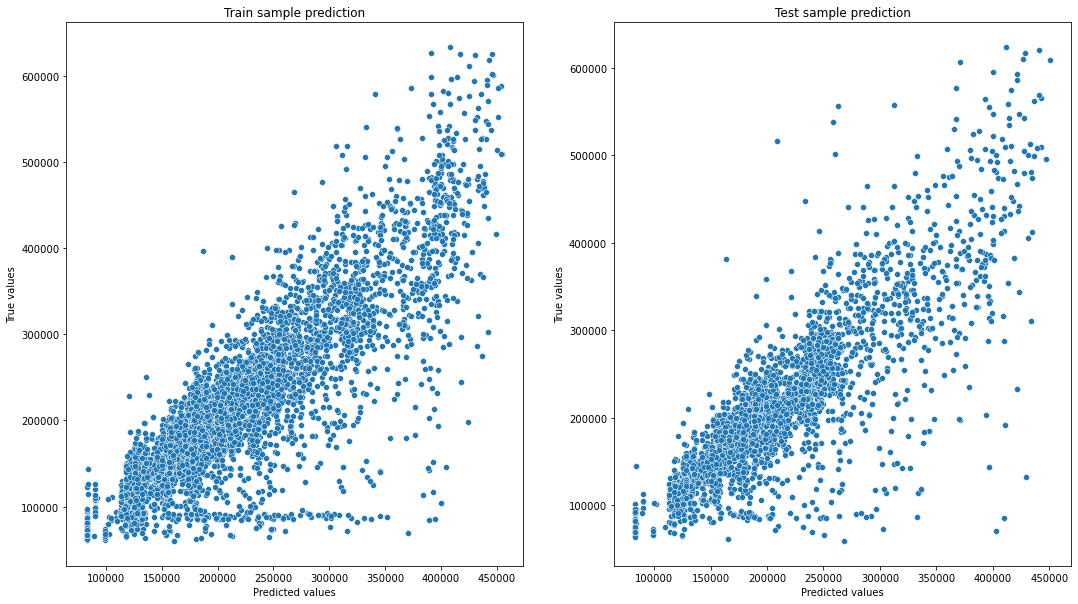

In [348]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)


In [349]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.499355
17,DistrictSize,0.295866
0,Rooms,0.061925
12,Social_3,0.053191
7,Ecology_1,0.019813
10,Social_1,0.017197
11,Social_2,0.012483
3,KitchenSquare,0.008645
13,Healthcare_1,0.007000
2,LifeSquare,0.006793


In [350]:
DATASET_test = './test.csv'

In [351]:
df_test = pd.read_csv(DATASET_test, sep=',')
df_test.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


Проделываем ту же самую очистку в тестовых данных

In [352]:
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()
df_test.loc[df_test['Square'] < 10, 'Square'] = 10
df_test.loc[(df_test['KitchenSquare'] < 4) & (df_test['KitchenSquare'] > 0) , 'KitchenSquare'] = 4
LifeSquare_Nan = df_test[df_test['LifeSquare'].isnull()].index
df_test.loc[LifeSquare_Nan, 'LifeSquare'] = (df_test.loc[LifeSquare_Nan, 'Square'] - df_test.loc[LifeSquare_Nan, 'KitchenSquare'] - 10)
floor_out = df_test[df_test['Floor'] > df_test['HouseFloor']].index
df_test.loc[floor_out, 'Floor'] = df_test.loc[floor_out, 'HouseFloor']
square_out = df_test[df_test['Square'] <  df_test['LifeSquare'] + df_test['KitchenSquare']].index
df_test.loc[square_out, 'Square'] = df_test.loc[square_out, 'LifeSquare'] + df_test.loc[square_out, 'KitchenSquare']
df_test.loc[df_test['Rooms'] >= 6, 'Rooms'] = 2
df_test.loc[df_test['Rooms'] < 1, 'Rooms'] = 2
Year_out = df_test[(df_test['HouseYear'] > 2021) | (df_test['HouseYear'] < 1914) ].index
df_test['Ecology_2_bin'] = df_test['Ecology_2'].replace({'A':0, 'B':1})
df_test['Ecology_3_bin'] = df_test['Ecology_3'].replace({'A':0, 'B':1})
df_test['Shops_2_bin'] = df_test['Shops_2'].replace({'A':0, 'B':1})
district_size = df_test['DistrictId'].value_counts(normalize = True).reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
df_test = df_test.merge(district_size, on='DistrictId', how='left')

In [353]:
test_preds = rf_model.predict(df_test[feature_names])
test_preds

array([157995.87671899, 132193.23802252, 159038.88871714, ...,
       150017.94518516, 203302.10906313, 263191.80589804])

In [359]:
test_id = df_test["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = test_preds
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./predictions_mikhailov.csv", index=False)

In [360]:
pred_df = pd.read_csv("./predictions_mikhailov.csv")
pred_df.head(n=2)

,Id,Price
0,4567,157995.876719
1,5925,132193.238023
